# Growthcleanr Data Exploration Tool

## Background

As stated in [Automated identification of implausible values in growth data from pediatric electronic health records](https://academic.oup.com/jamia/article/24/6/1080/3767271):

> In pediatrics, evaluation of growth is fundamental, and many pediatric research studies include some aspect of growth as an outcome or other variable. The clinical growth measurements obtained in day-to-day care are susceptible to error beyond the imprecision inherent in any anthropometric measurement. Some errors result from minor problems with measurement technique. While these errors can be important in certain analyses, they are often small and generally impossible to detect after measurements are recorded. Larger measurement technique errors can result in values that are biologically implausible and can cause problems for many analyses. 

## Growthcleanr

[growthcleanr](https://github.com/carriedaymont/growthcleanr) is an automated method for cleaning longitudinal pediatric growth data from EHRs. It is available as open source software.

## Data Exploration Tool

The objective of this tool is to allow users to analyze how growthcleanr is performing on a data set. This tool is to be used **after** a data set has been run through growthcleanr.

This tool is a [Juypter Notebook](https://jupyter.org/). It provides an environment that includes graphical user interfaces as well as interactive software development to explore data. This notebook uses the [Python programming language](https://www.python.org/). The Python code is used to import, transform, visualize and analyze the output of growthcleanr. Some of the code for the tool is directly included in this notebook. Other functions have been placed in an external file to minimize the amount of code that users see in order to let them focus on the actual data.

Data analysis is performed using [NumPy](https://numpy.org/) and [Pandas](https://pandas.pydata.org/). The output of growthcleanr will be loaded into a [pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html). This tool expects the output to be in a [CSV format that is described later on in the notebook](#input_structure). This tool provides functions for transforming DataFrames to support calculation of some values, such as BMI, as well as supporting visualizations. It is expected that users will create views into or copies of the DataFrames built initially by this tool. Adding columns to the DataFrames created by this tool is unlikely to cause problems. Removing columns is likely to break some of the tool's functionality.

Visualization in the tool is provided by [Matplotlib](https://matplotlib.org/) and [Seaborn](http://seaborn.pydata.org/). Users may generate their own charts with these utilities.

---
# Setting Up the Environment

Jupyter Notebooks have documentation cells, such as this one, and code cells like the one below. The notebook server can runs the code and provides results (if applicable) back in the notebook. The following code cell loads the libraries necessary for the tool to work. If you would like to incorporate other Python libraries to assist in data exploration, they can be added here. Removing libraries from this cell will very likely break the tool.

In [1]:
from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import seaborn as sns
from IPython.display import FileLink, FileLinks

The next two code cells tell the notebook server to automatically reload the externally defined Python functions created to assist in data analysis.

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

This code cell instructs the notebook to display plots automatically inline

In [4]:
%matplotlib inline

This code cell tells the notebook to output plots for high DPI displays, such as 4K monitors, many smartphones or a retina display on Apple hardware. This cell does not need to be run and can be safely removed. If removed, charts will look more "blocky" or "pixelated" on high DPI displays.

In [5]:
%config InlineBackend.figure_format = 'retina'

# Loading Data

The following cell import functions created for the tool to asssist in data analysis. Some of the functions generate charts used in this tool. The chart code may be modified to change the appearance of plots without too much risk of breaking things. Other functions transform DataFrames and changing those will very likely cause things to break. If you are unable to tell the difference in the functions by looking at the code, it is probably best to leave them unmodified.

In [6]:
import charts

This cell reads in a data set that has been run through the [growthcleanr](https://github.com/carriedaymont/growthcleanr) algorithm. Details of the algorithm can be found in [Automated identification of implausible values in growth data from pediatric electronic health records](https://academic.oup.com/jamia/article/24/6/1080/3767271)

<a id="input_structure"></a>
Data is expected to be in a CSV file with the following structure:

| Column | Description |
|--------|-------------|
| id | A unique identifier for an observation |
| subjid | An identifier for the individual from which the observation was obtained |
| sex | A numeric value of 0 (male) or 1 (female). Note that this differs from the CDC Growth Chart Data Tables. |
| agedays | Number representing the age of the patient in days when the observation was obtained |
| param | The type of observation along with units. Expected values are *HEIGHTCM* and *WEIGHTKG* |
| measurement | A decimal number that represents the observation value. |
| clean_value | The categorization of the observation by growthcleanr. |

This information will be loaded into a [pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) called `cleaned_obs`

In [7]:
cleaned_obs = pd.read_csv("clean_with_swaps.csv")

The following cell shows what the first five rows look like in the CSV file

In [8]:
cleaned_obs.head()

,id,subjid,sex,agedays,param,measurement,clean_value
0,1,46663895,0,2970,HEIGHTCM,121.920000,Include
1,2,46663895,0,3776,HEIGHTCM,152.400000,Include
2,3,46663895,0,2970,WEIGHTKG,24.494239,Include
3,4,46663895,0,3776,WEIGHTKG,40.823732,Include
4,5,46668331,0,2959,HEIGHTCM,116.840000,Include


Next, the `charts.setup_individual_obs_df` function performs transformations on the `cleaned_obs` DataFrame. This will create an `age` column, which is a decimal column that represents the patient's age in years at the time of the observation. It changes the `clean_value` column into a [pandas categorical type](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html). It also create an `include` column which contains a boolean value indicating whether growthcleanr states to include (true) or exclude (false) the observation. The resulting DataFrame is assigned to `obs`.

In [9]:
obs = charts.setup_individual_obs_df(cleaned_obs)

The following cell loads in the [CDC Growth Chart Percentile Data Files](https://www.cdc.gov/growthcharts/percentile_data_files.htm). Functions coerce some values into numeric types. It also add an `age` column which is a decimal value representing age in years. Finally, `Sex` is transformed so that the values align with the values used in growthcleanr, 0 (male) or 1 (female). This data is used to plot percentile bands in visualizations in the tool. 

In [10]:
bmi_percentiles = pd.read_csv("bmiagerev.csv")
bmi_percentiles = charts.setup_percentiles(bmi_percentiles)
wt_percentiles = pd.read_csv("wtage.csv")
wt_percentiles = charts.setup_percentiles(wt_percentiles)
ht_percentiles = pd.read_csv("statage.csv")
ht_percentiles = charts.setup_percentiles(ht_percentiles)

In a previous cell, the tool creates the `obs` DataFrame. In that structure there is one measurement, either height or weight, per row. In this cell, the `charts.setup_merged_df` function will create a DataFrame where a height observation and weight observation for the same `subjid` on the same `agedays` are combined into a single row. Several new columns are added to the resulting DataFrame:

| Column | Description |
|--------|-------------|
| weight | The `measurement` value for observations that had the `param` of *WEIGHTKG* |
| height | The `measurement` value for observations that had the `param` of *HEIGHTCM* |
| bmi | The BMI calculated from `weight` and `height` |
| weight_cat | The value previously stored in `clean_value` for the weight observation |
| include_weight | The value previously stored in `include` for the weight observation |
| height_cat | The value previously stored in `clean_value` for the height observation |
| include_height | The value previously stored in `include` for the height observation |
| include_both | Logical AND of `include_weight` and `include_height` |

The result is stored in `merged_df`.

In [11]:
merged_df = charts.setup_merged_df(obs)

# Finding Individuals

This next cell creates interactive tool can be used to explore patients. The `charts.top_ten` function will create a DataFrame showing the 10 items from the passed in `merged_df` based on the passed in selection criteria. The selection criteria are determined by interacting with the generated user interface. The tool uses [ipywidgets](https://ipywidgets.readthedocs.io/en/latest/) to create the user interface.

In [12]:
age_options = widgets.IntRangeSlider(value=[2, 20], min=2, max=20, step=1, description='Age:', 
                                     continuous_update=False,
                                     orientation='horizontal', readout=True, readout_format='d')

exclusion_options = []
for c in cleaned_obs.clean_cat.unique():
  exclusion_options.append((c, c))
exclusion_values = [x[1] for x in exclusion_options] 

weight_exclusions = widgets.SelectMultiple(options=exclusion_options, 
                                           value=exclusion_values, rows=17,
                                           description='Weight Exclusions')
height_exclusions = widgets.SelectMultiple(options=exclusion_values, 
                                           value=exclusion_values, rows=17,
                                           description='Height Exclusions')
field_selector = widgets.Dropdown(options=["height", "weight", "bmi"], description='Field: ')
sex_selector = widgets.Dropdown(options=[('Any', None), ('Female', 1), ('Male', 0)], description='Sex:')
order_selector = widgets.Dropdown(options=['largest', 'smallest'], description='Order:')
out = widgets.Output()

top_row = widgets.HBox([field_selector, age_options, sex_selector])
middle_row = widgets.HBox([weight_exclusions, height_exclusions])
ui = widgets.VBox([top_row, middle_row, order_selector])

widgets.interactive_output(charts.top_ten, {'merged_df': fixed(merged_df), 
                                            'field': field_selector, 
                                            'age': age_options, 
                                            'sex': sex_selector, 
                                            'wexclusion': weight_exclusions, 
                                            'hexclusion': height_exclusions, 
                                            'order': order_selector, 
                                            'out': fixed(out)})

display(ui, out)

Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': '         subjid  sex         height_ca…

It can be useful to copy values from the `subjid` column in the results above for use in visualizations in the rest of the tool.

---

# Visualizing an Individual Trajectory

The cell below creates a plot for an individual. It shows either the weight trajectory or height tragectory depending on the `param` value that is selected. The black bands in the diagram represent the 5th and 95th percentile values for age and sex for the given measurement type.

In this chart, the blue line represents all measurements for an individual. Any values marked for exclusion are represented with a red x. The yellow dashed line represents the trajectory with exclusions removed. Any carried forward values are represented by a blue triangle, unless `include_carry_forward` is set to False, when they will also be represented as a red x.

In [13]:
interactive(charts.overlap_view, obs_df=fixed(obs), 
            subjid=widgets.BoundedIntText(value=47085108,
                                          min=0,
                                          max=100000000,
                                          description='Subject ID:',
                                          disabled=False), 
            param=['HEIGHTCM', 'WEIGHTKG'], 
            include_carry_forward=[True, False], 
            include_percentiles=[True, False],
            wt_df=fixed(wt_percentiles), ht_df=fixed(ht_percentiles))

interactive(children=(BoundedIntText(value=47085108, description='Subject ID:', max=100000000), Dropdown(descr…

# Visualizing Multiple Trajectories at Once

Next, the tool creates a series that contains the unique set of `subjid`s and stores that in `uniq_ids`.

In [14]:
uniq_ids = cleaned_obs['subjid'].unique()

From the series of unique ids, the following cell randonly selects 25 individuals and assigns them to `sample`.

In [15]:
sample = np.random.choice(uniq_ids, size=25, replace=False)

In [16]:
sample

array([47081710, 46840752, 46884326, 46851268, 46945606, 47086480,
       46854361, 46941085, 46965356,   496334, 46967219, 46839755,
       46965995, 46833521, 46987585, 47102415, 46971344, 46928242,
       46814743, 47024291, 47123406, 47105271, 46745458, 46986613,
       46782268])

The `sample` can be passed into the `charts.four_by_four_view` function which will create a [small multiple](https://en.wikipedia.org/wiki/Small_multiple) plot for each of the individuals. Exclusions, including carry forwards, will be represented by a red x.

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py'>

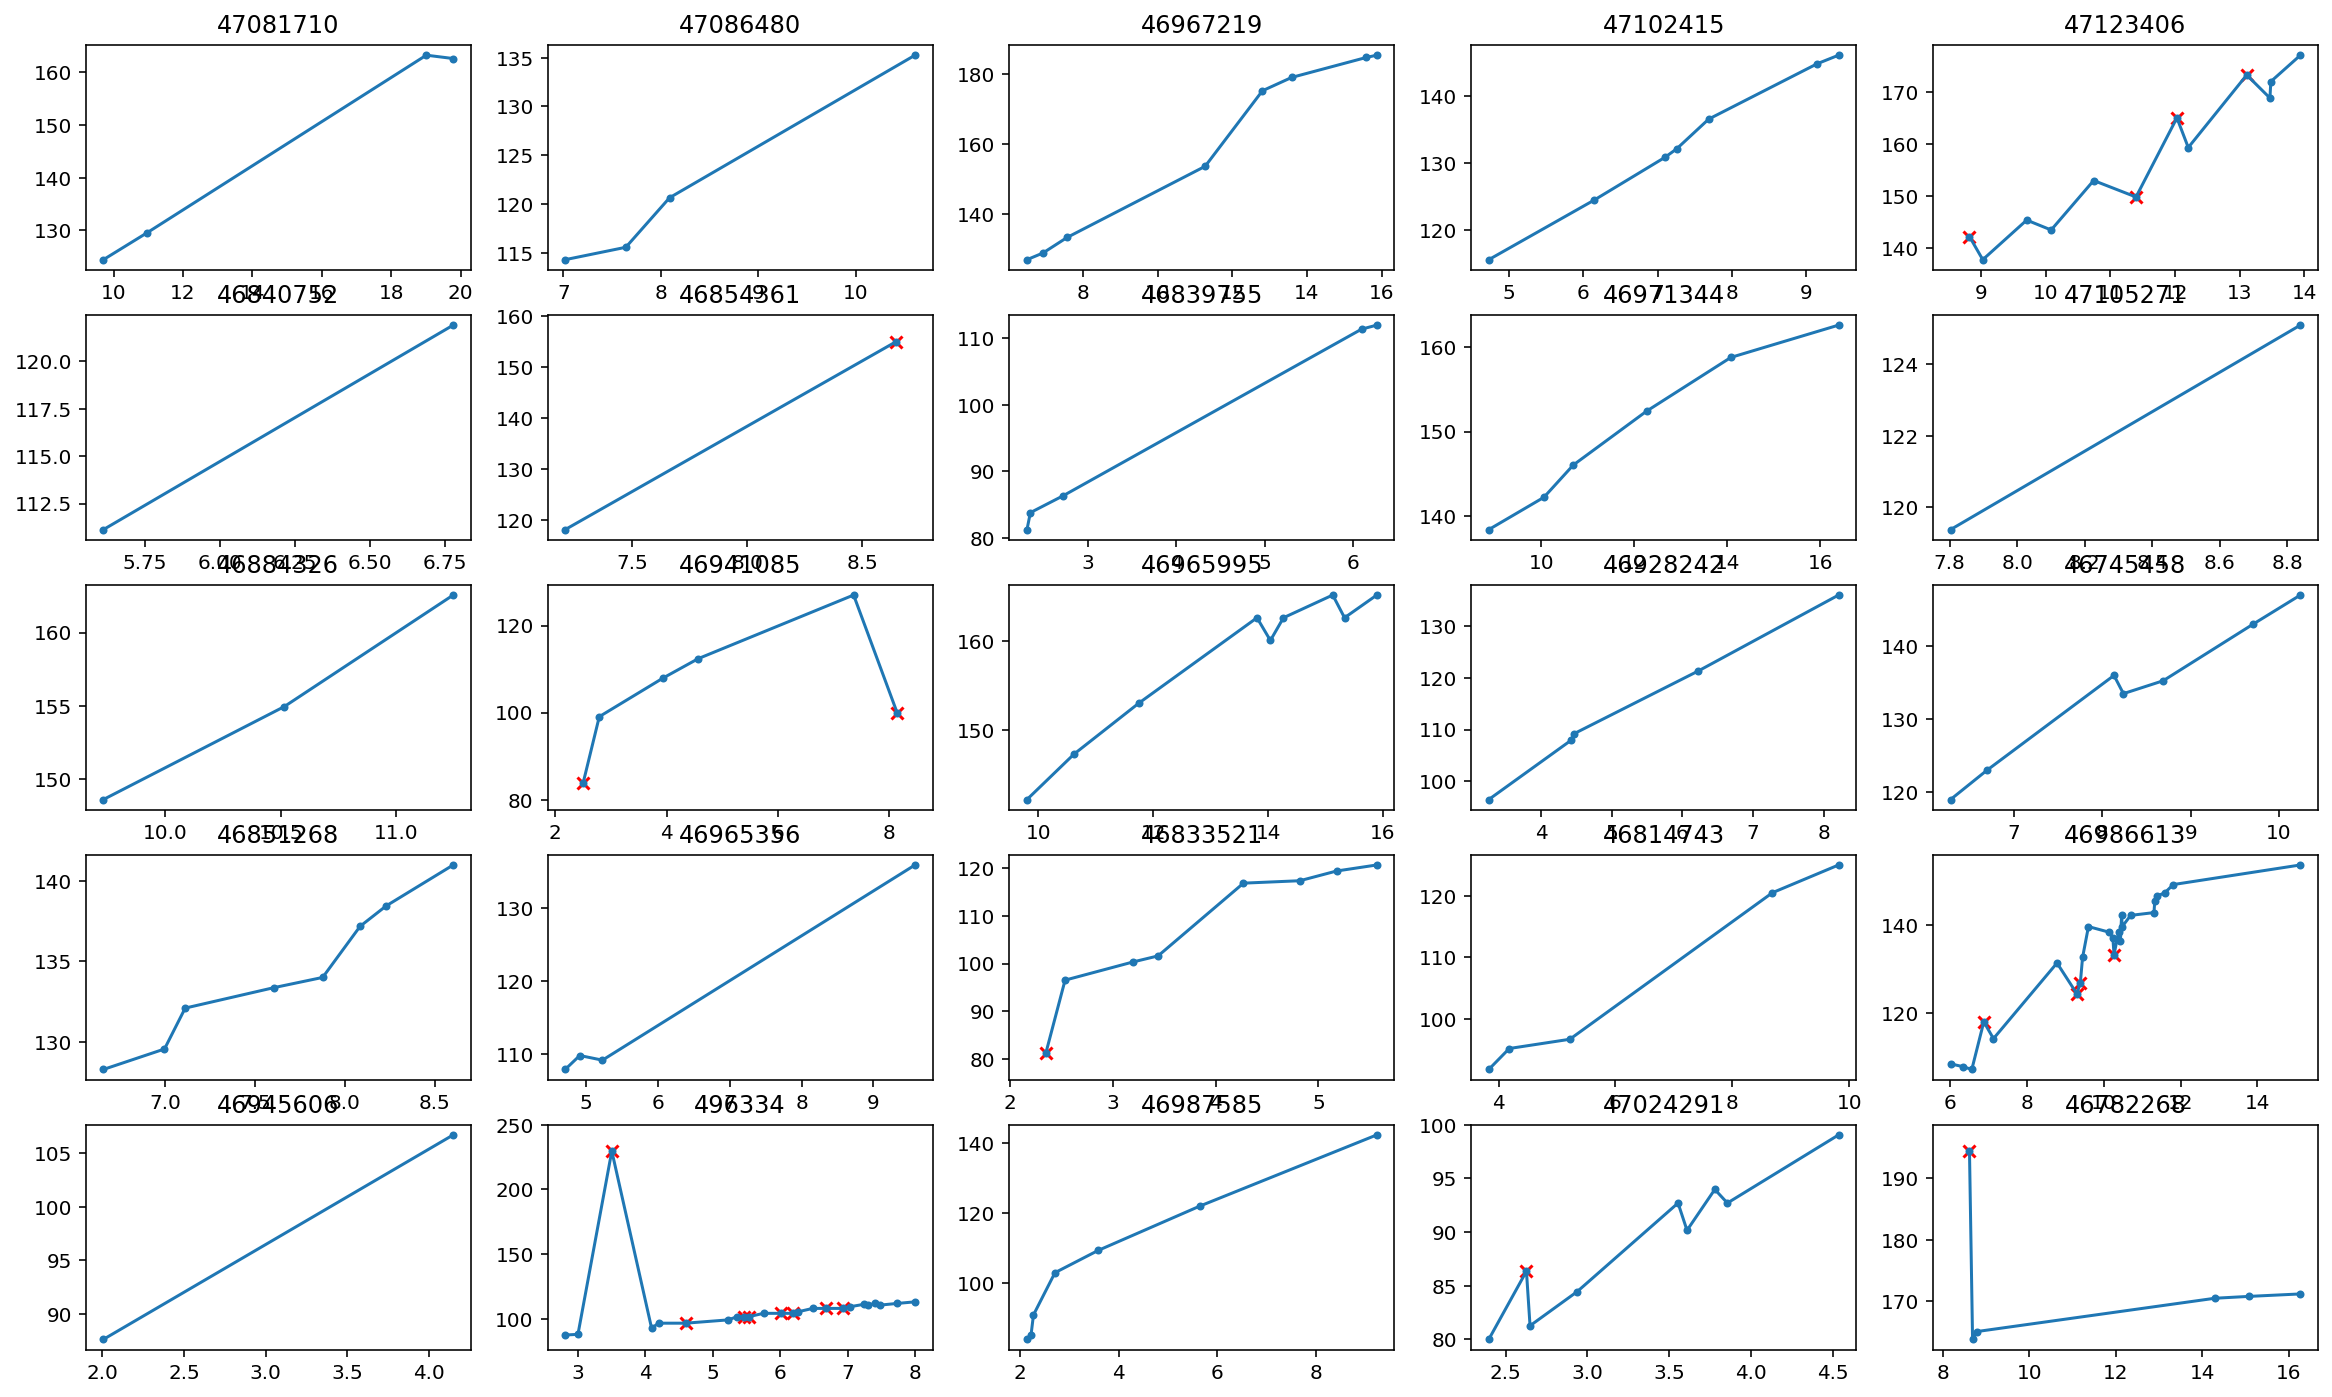

In [17]:
charts.five_by_five_view(cleaned_obs, sample, 'HEIGHTCM')

# Building a Different Sample

This tool can be used to create samples that are tailored to specific interests. Views can easily be created on existing DataFrames and be used to generate different samples. Functionality available is described in the [Pandas DataFrame documentation](https://pandas.pydata.org/pandas-docs/stable/reference/frame.html).

The cell below selects all observations with a weight exclusion of "Exclude-EWMA-Extreme". It then sorts by weight in descending order. The code then takes the top 50 values and selects 25 random, unique `subjids` from that set. Finally it plots the results.

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py'>

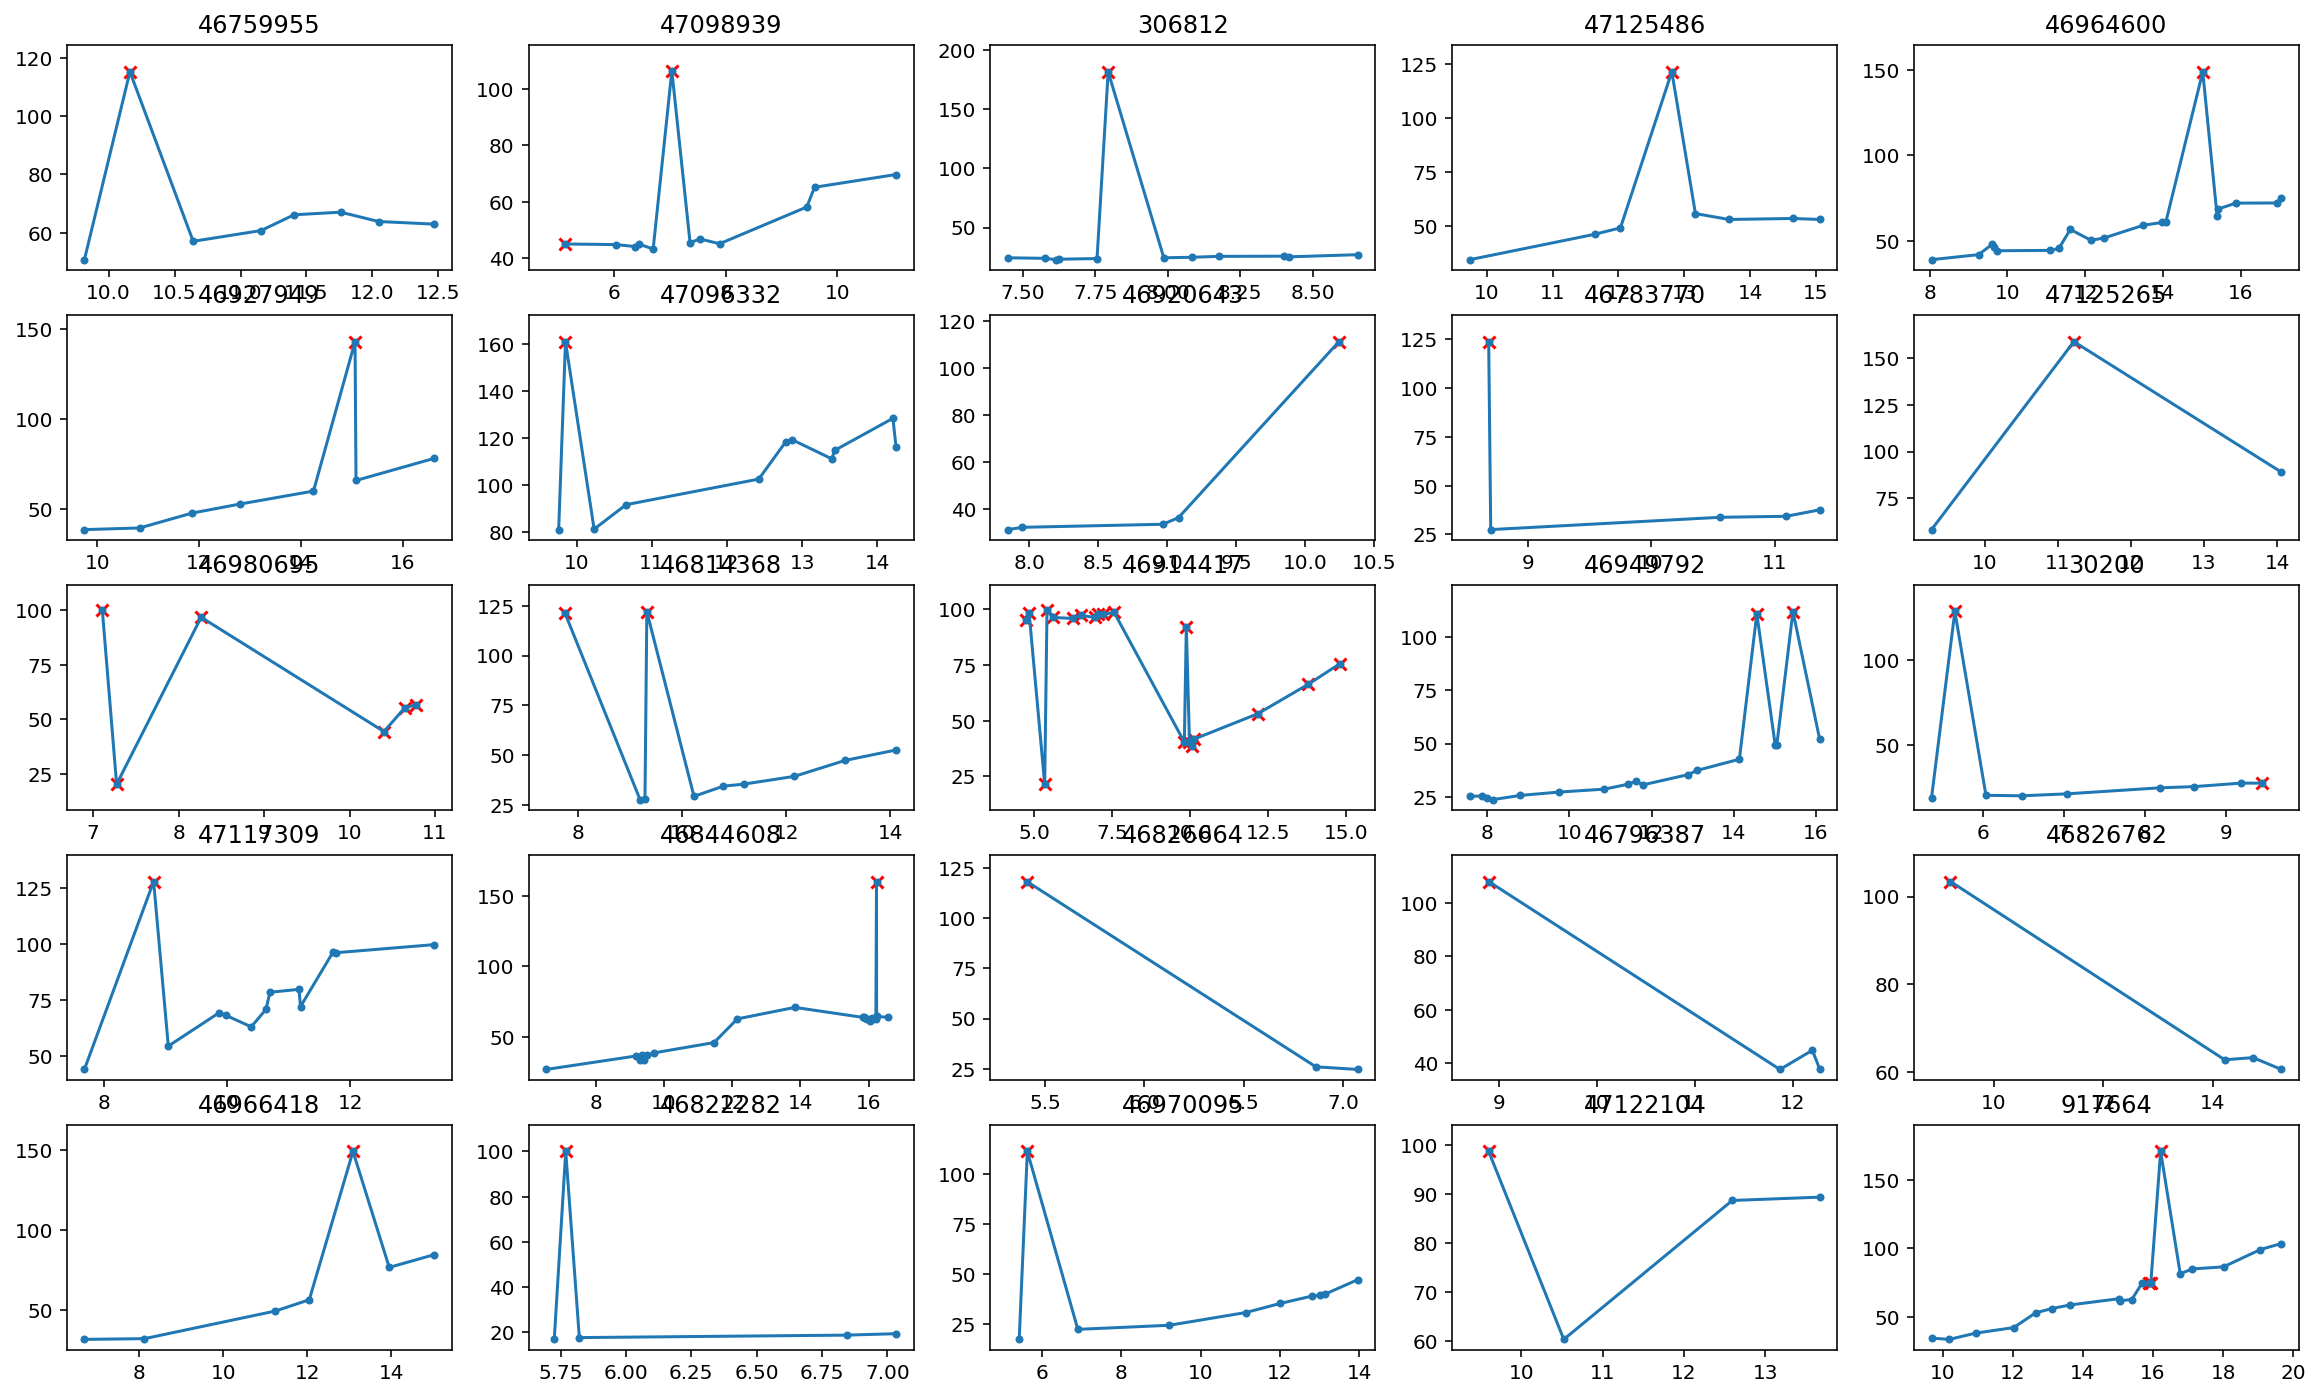

In [18]:
top_weight_extreme_ewma_ids = merged_df[merged_df.weight_cat == 'Exclude-EWMA-Extreme'].sort_values('weight', ascending=False).head(50)['subjid'].unique()
ewma_sample = np.random.choice(top_weight_extreme_ewma_ids, size=25, replace=False)
charts.five_by_five_view(cleaned_obs, ewma_sample, 'WEIGHTKG')

# Visualizing Changes in Trajectory

The `charts.bmi_with_percentiles` function displays a chart showing BMI for an individual over time. Black bands representing the 5th and 95th BMI percentile for age and sex are shown with the individual's BMI shown in blue. The plot on the left represents all values. The plot on the right is only included values.

In [19]:
interact(charts.bmi_with_percentiles, merged_df = fixed(merged_df), 
                                      bmi_percentiles = fixed(bmi_percentiles),
                                      subjid = widgets.BoundedIntText(value=46717134,
                                                                      min=0,
                                                                      max=100000000,
                                                                      description='Subject ID:',
                                                                      disabled=False
))

interactive(children=(BoundedIntText(value=46717134, description='Subject ID:', max=100000000), Output()), _do…

<function charts.bmi_with_percentiles(merged_df, bmi_percentiles, subjid)>

# Summary Statistics

The next cell generates summary statistics for the data set. The `charts.bmi_stats` function uses the `merged_df` DataFrame to compute values on the "clean" data, which means only included values as well as the "raw" values, which is all values for individuals.

The buttons can be used to add or remove columns from the table.

In [20]:
min_toggle = widgets.ToggleButton(value=True, description='Minimum BMI')
mean_toggle = widgets.ToggleButton(value=True, description='Mean BMI')
max_toggle = widgets.ToggleButton(value=True, description='Maximum BMI')
std_toggle = widgets.ToggleButton(value=True, description='BMI Standard Deviation')
med_toggle = widgets.ToggleButton(value=True, description='Median BMI')
count_toggle = widgets.ToggleButton(value=True, description='Count')
diff_toggle = widgets.ToggleButton(value=True, description='Mean BMI Difference')
age_range = widgets.IntRangeSlider(value=[2, 20], min=2, max=20, step=1, description='Age:', continuous_update=False,
                                   orientation='horizontal', readout=True, readout_format='d')
hbox = widgets.HBox([min_toggle, mean_toggle, max_toggle, std_toggle, med_toggle, count_toggle, diff_toggle])
ui = widgets.VBox([age_range, hbox])
out = widgets.Output()
widgets.interactive_output(charts.bmi_stats, {'merged_df': fixed(merged_df), 'include_min': min_toggle, 
         'include_mean': mean_toggle, 'include_max': max_toggle, 'include_std': std_toggle, 
         'include_median': med_toggle, 'include_mean_diff': diff_toggle, 'include_count': count_toggle,
         'out': fixed(out), 'age_range': age_range})
display(ui, out)

Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': '<pandas.io.formats.style.Styler at 0x1…

The following shows the counts of the values for inclusion/exclusion

In [21]:
obs.groupby('param').clean_cat.value_counts()

param     clean_cat                              
HEIGHTCM  Include                                    48331
          Exclude-Min-Height-Change                   1871
          Exclude-Carried-Forward                     1608
          Exclude-EWMA-8                               722
          Exclude-EWMA-Extreme                         671
          Exclude-SD-Cutoff                            441
          Exclude-Too-Many-Errors                      389
          Exclude-EWMA-9                               187
          Exclude-Single-Outlier                        91
          Exclude-EWMA-Extreme-Pair                     80
          Exclude-Too-Many-Errors-Other-Parameter       44
          Exclude-EWMA-11                               41
          Swapped-Measurements                          26
          Exclude-Max-Height-Change                     15
          Exclude-Pair-Delta-17                         15
          Exclude-EWMA-12                                3
      

The following cell generates a bar chart that counts the types of exclusions. They are grouped by `param` so that the bars represent exclusions for height or weight.

Removing `hue='param'` from the code below will generate a bar chart where exclusions are grouped by type and height and weight are combined.

The below chart also removes included values, as that tends to dominate the dataset. Included values can be shown by changing `data=obs[obs.include == False]` to `data=obs` 

# Exporting Data

The following code allows you to export a DataFrame as a CSV file. When the cell below is run, the drop down will contain all DataFrames stored in variables in this notebook. Select the desired DataFrame and click Generate CSV. This will create the CSV file and provide a link to download it.

In [22]:
df_selector = widgets.Dropdown(options=charts.data_frame_names(locals()), description='Data Frames')
generate_button = widgets.Button(description='Generate CSV')
ui = widgets.VBox([df_selector, generate_button])
out = widgets.Output()

l = locals()
def on_button_clicked(b):
    charts.export_to_csv(l, df_selector, out)

generate_button.on_click(on_button_clicked)
    
display(ui, out)

Output()

# Post Processing Data

This tool provides functions that allow the post processing of data. `charts.clean_swapped_values` will look in a DataFrame for rows where the `height_cat` and `weight_cat` are set to "Swapped-Measurements". It will then swap the `height` and `weight` values for those rows. It will also create two new columns: `postprocess_height_cat` and `postprocess_weight_cat`. The values for these columns is copied from the original categories except in the case where swaps are fixed when it is set to "Include-Fixed-Swap".

The cell below copies the merged DataFrame and then cleans the swapped values.

In [23]:
cleaned = merged_df.copy()
cleaned = charts.clean_swapped_values(cleaned)
cleaned[cleaned.height_cat == 'Swapped-Measurements'].head()

,id_x,subjid,sex,agedays,height_cat,include_height,height,weight_cat,age,include_weight,weight,bmi,rounded_age,include_both,postprocess_height_cat,postprocess_weight_cat
44000,88002,23809,0,5096,Swapped-Measurements,False,154.5,Swapped-Measurements,13.961644,False,42.6,851.352245,14.0,False,Include-Fixed-Swap,Include-Fixed-Swap
44101,88204,34931,1,2476,Swapped-Measurements,False,127.0,Swapped-Measurements,6.783562,False,31.8,1255.883865,7.0,False,Include-Fixed-Swap,Include-Fixed-Swap
44116,88234,36587,0,3728,Swapped-Measurements,False,146.8,Swapped-Measurements,10.213699,False,52.3,536.688980,10.0,False,Include-Fixed-Swap,Include-Fixed-Swap
44124,88250,37591,0,4527,Swapped-Measurements,False,163.0,Swapped-Measurements,12.402740,False,85.2,224.547599,12.0,False,Include-Fixed-Swap,Include-Fixed-Swap
44299,88600,50796,1,4991,Swapped-Measurements,False,161.6,Swapped-Measurements,13.673973,False,65.3,378.978868,14.0,False,Include-Fixed-Swap,Include-Fixed-Swap


# Developing New Visualizations

Users may take advantage of the predefined `charts.bmi_stats`, `charts.bmi_with_percentiles`, `charts.five_by_five_view`, `charts.overlap_view` and `charts.top_ten` functions. For more information on these functions, execute the function name ending with a "?", which will bring up the inline help window. For example, `charts.five_by_five_view`

In [24]:
charts.bmi_stats?

In addition, users can take advantage of all of the plotting capabilities of [Matplotlib](https://matplotlib.org/3.1.1/tutorials/index.html) and [Seaborn](https://seaborn.pydata.org/tutorial.html)

## Calculating Modified Z Scores

The following function will calculate the modified Z Score for all weights in the merged_df DataFrame. The modified Z Scores are calculated using the formulas described in [Modified z-scores in the CDC growth charts](https://www.cdc.gov/nccdphp/dnpa/growthcharts/resources/BIV-cutoffs.pdf)

In [25]:
mwzs = charts.calculate_modified_weight_zscore(merged_df, wt_percentiles)

The following code will determine the absolute modified Z Score for weight the 99.9th percentile of measurements that were included by growthcleanr in the data set.

In [26]:
np.absolute(mwzs.loc[mwzs.include_weight == True].wt_mzscore).quantile(0.999)

6.956217141577131

This line selects all subjids that have at least one weight measurement that has been included by growthcleanr and above the 99.9th percentile for modified Z score.

In [27]:
cutoff_ids = mwzs.loc[(np.absolute(mwzs.wt_mzscore) > 6.95) & (mwzs.include_weight == True)].subjid.unique()

In [28]:
cutoff_sample = np.random.choice(cutoff_ids, size=25, replace=False)

Visualization of a single subject with measurements above the cut off. Values above the cutoff are represented as a blue dot.

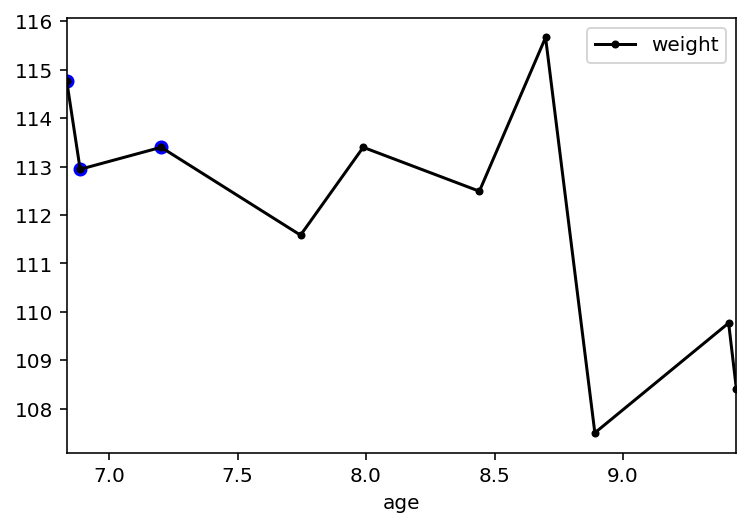

In [29]:
charts.cutoff_view(mwzs, 46785745, 6.95, wt_percentiles)

## Comparing different runs of growthcleanr

This tool contains code to compare different runs of growth cleaner. The following code will load two separate runs of growthcleaner. The first is a data set that includes the data used above, but with additional subjects that have swapped measurements. The second run looks at the same data, but turns on growthcleanr's ability to detect unit errors.

In [30]:
cws = pd.read_csv("clean_with_swaps.csv")
cws = charts.setup_individual_obs_df(cws)
cwus = pd.read_csv("clean_with_uswaps.csv")
cwus = charts.setup_individual_obs_df(cwus)

The next cell uses the `prepare_for_comparison` function to combine the two loaded and prepared DataFrames into a single DataFrame that tags the rows with the name of the run.

In [31]:
combined = charts.prepare_for_comparison({'swaps': cws, 'unit errors': cwus})

With this `combined` DataFrame, several functions are available to display differences between the runs. `category_counts` shows the raw number of measurements for each category. It also shows the difference between the runs and percentage change in the number of raw measurements. This function and other comparison functions can be used with more than two separate runs. In these cases, the functions will not compute difference or percentage change.

In [32]:
charts.count_comparison(combined)

run_name,swaps,unit errors,diff
clean_value,,,
Exclude-Carried-Forward,2144.0,2144.0,0.0
Exclude-EWMA-11,56.0,56.0,0.0
Exclude-EWMA-12,8.0,8.0,0.0
Exclude-EWMA-8,1036.0,1028.0,8.0
Exclude-EWMA-9,321.0,321.0,0.0
Exclude-EWMA-Extreme,1173.0,722.0,451.0
Exclude-EWMA-Extreme-Pair,140.0,140.0,0.0
Exclude-Max-Height-Change,15.0,15.0,0.0
Exclude-Min-Height-Change,1871.0,1871.0,0.0


The following cell uses the `subject_comparison_category_counts` to display the count of subjects who have a measurement with at least one of the measurement categories.

In [33]:
charts.subject_comparison_category_counts(combined)

run_name,swaps,unit errors,diff,percent change
clean_value,,,,
Exclude-Carried-Forward,574.0,574.0,0.0,0.000000
Exclude-EWMA-11,53.0,53.0,0.0,0.000000
Exclude-EWMA-12,8.0,8.0,0.0,0.000000
Exclude-EWMA-8,812.0,807.0,5.0,-0.615764
Exclude-EWMA-9,280.0,280.0,0.0,0.000000
Exclude-EWMA-Extreme,860.0,485.0,375.0,-43.604651
Exclude-EWMA-Extreme-Pair,100.0,100.0,0.0,0.000000
Exclude-Max-Height-Change,15.0,15.0,0.0,0.000000
Exclude-Min-Height-Change,1236.0,1237.0,-1.0,0.080906


The following cell uses `subject_comparison_percentage` to show a percentage of subjects who have at least one measurement in the category

In [34]:
charts.subject_comparison_percentage(combined)

run_name,swaps,unit errors,diff
clean_value,,,
Exclude-Carried-Forward,6.415558,6.415558,0.000000
Exclude-EWMA-11,0.592377,0.592377,0.000000
Exclude-EWMA-12,0.089415,0.089415,0.000000
Exclude-EWMA-8,9.075668,9.019783,0.055885
Exclude-EWMA-9,3.129541,3.129541,0.000000
Exclude-EWMA-Extreme,9.612161,5.420811,4.191349
Exclude-EWMA-Extreme-Pair,1.117693,1.117693,0.000000
Exclude-Max-Height-Change,0.167654,0.167654,0.000000
Exclude-Min-Height-Change,13.814686,13.825863,-0.011177


## Looking at exclusion prevalence between data sets

The following visualizations show exclusions at age. Each plot shows a single exclusion type with the different runs shown in different colors.

In [35]:
combined['rounded_age'] = np.around(combined.age)

In [36]:
count_by_age = combined.groupby(['run_name', 'clean_value', 'rounded_age']).agg({'id': 'count'}).reset_index()

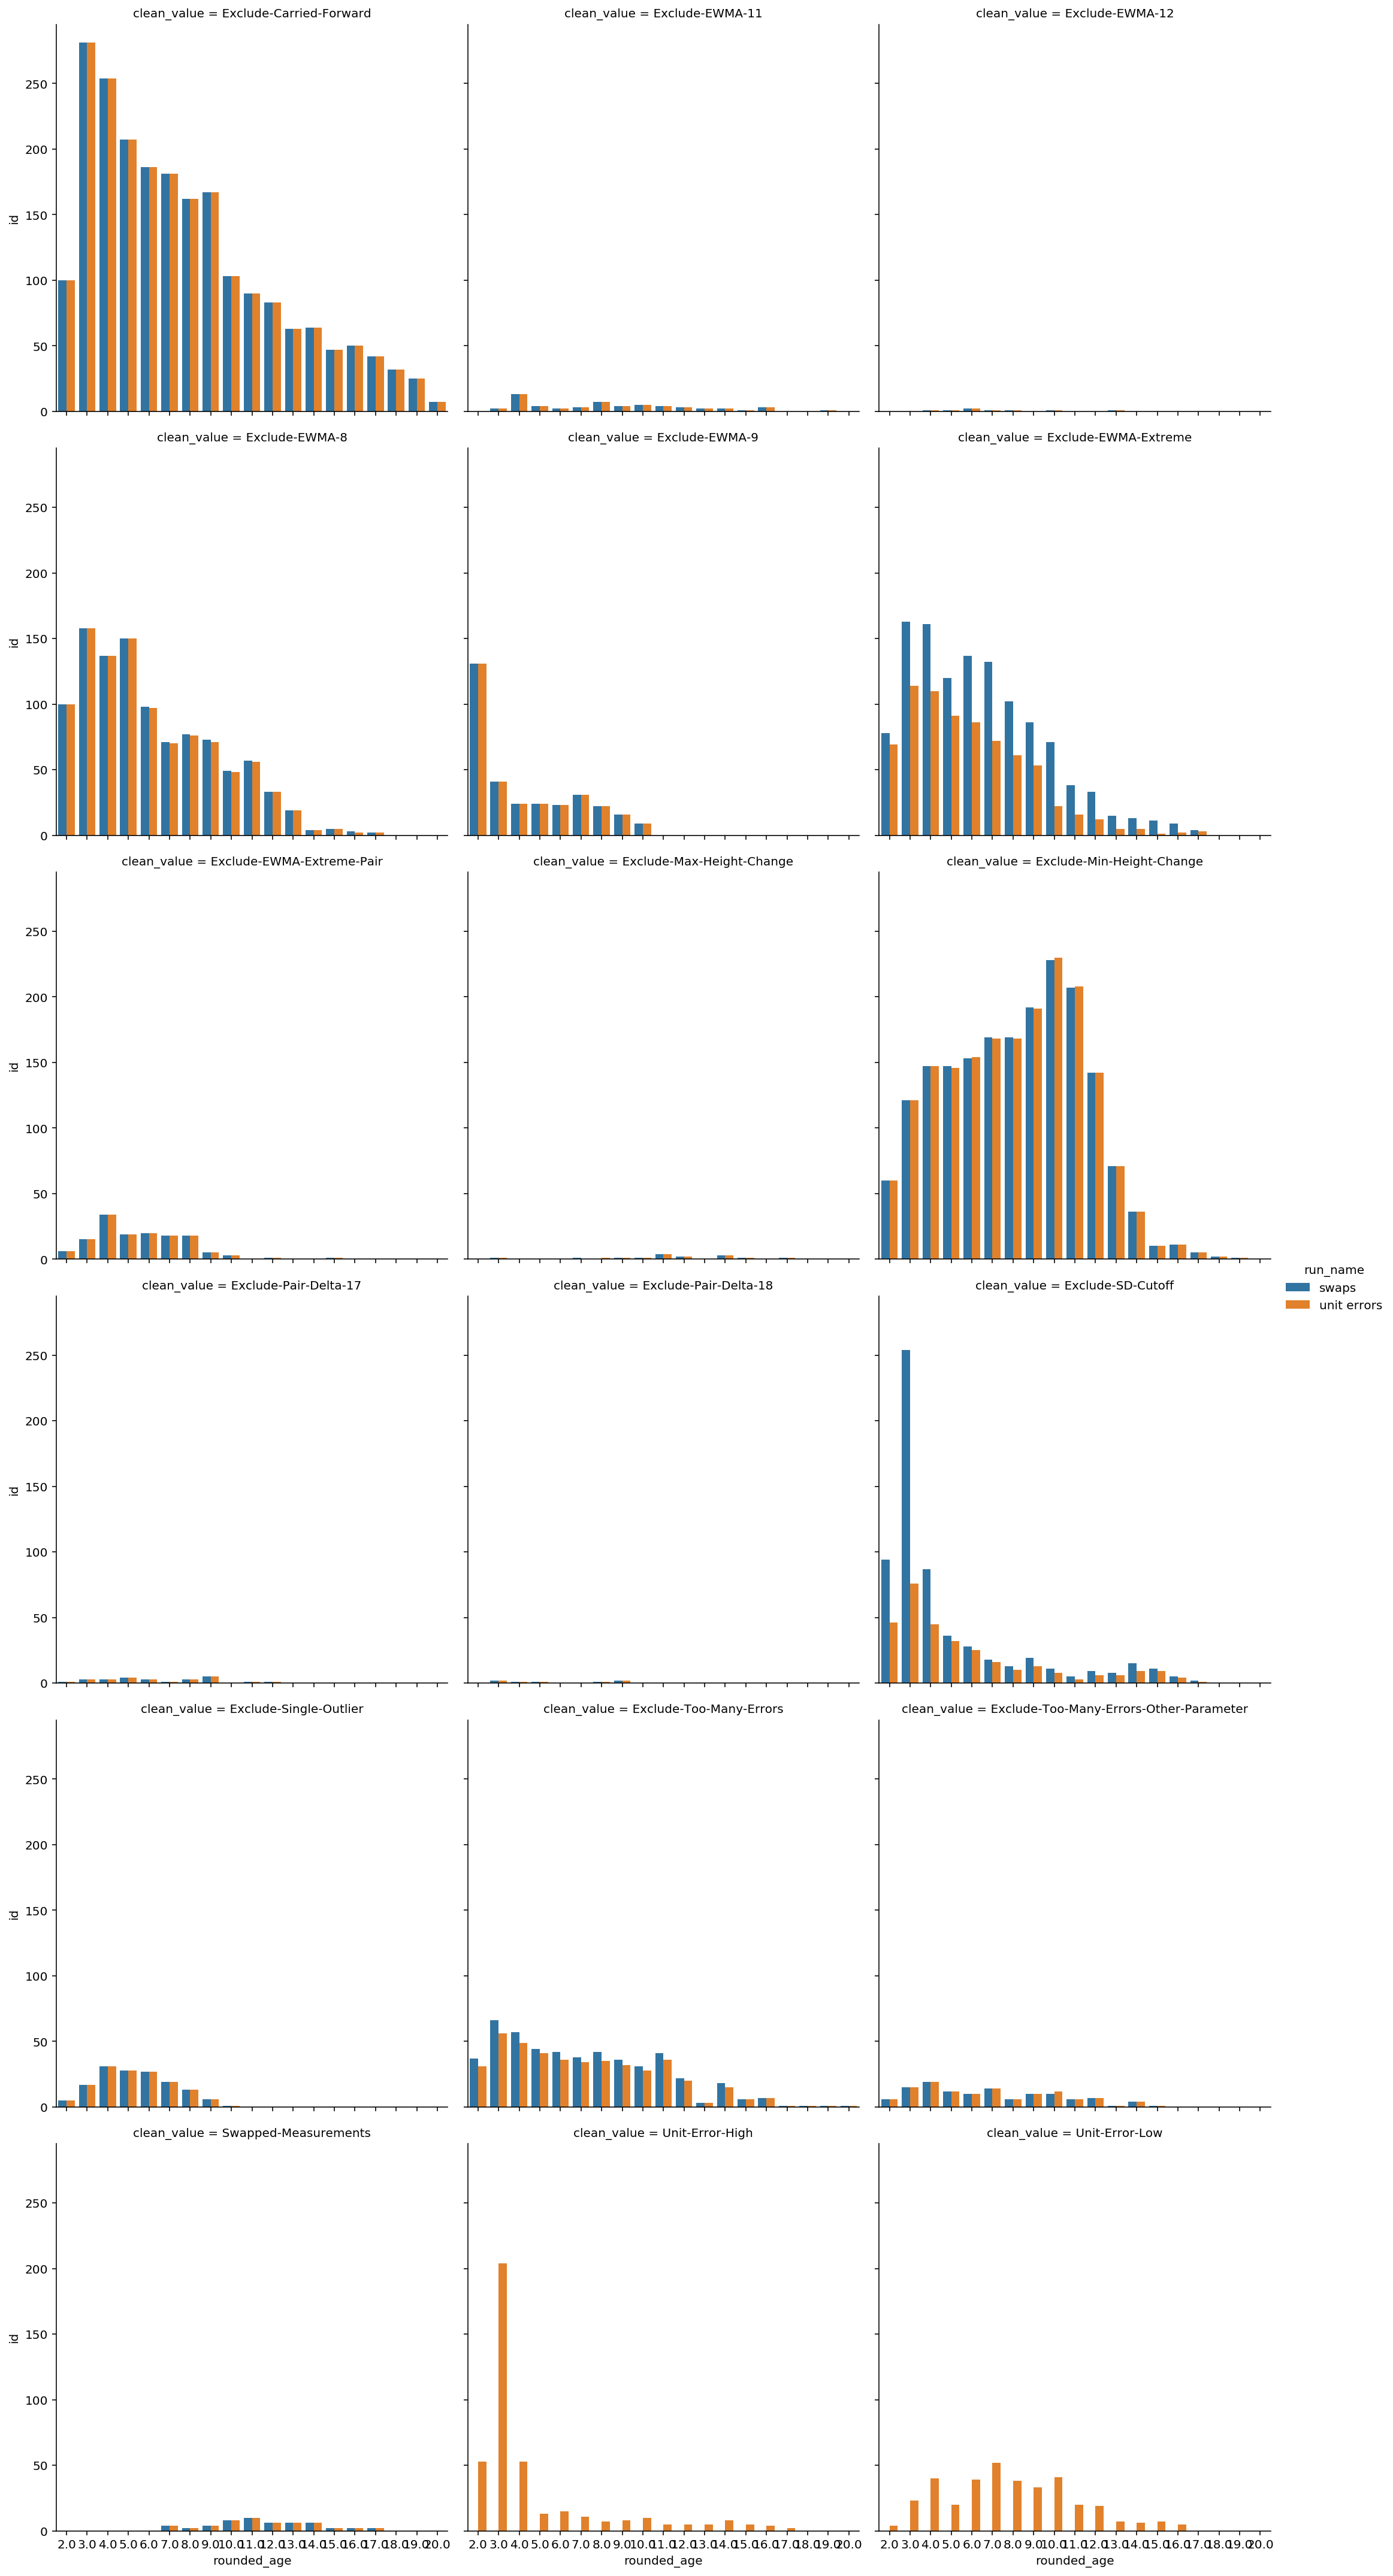

In [37]:
p = sns.catplot(x='rounded_age', y='id', col='clean_value', data=count_by_age[count_by_age.clean_value != 'Include'], hue='run_name', col_wrap=3, kind="bar")
p

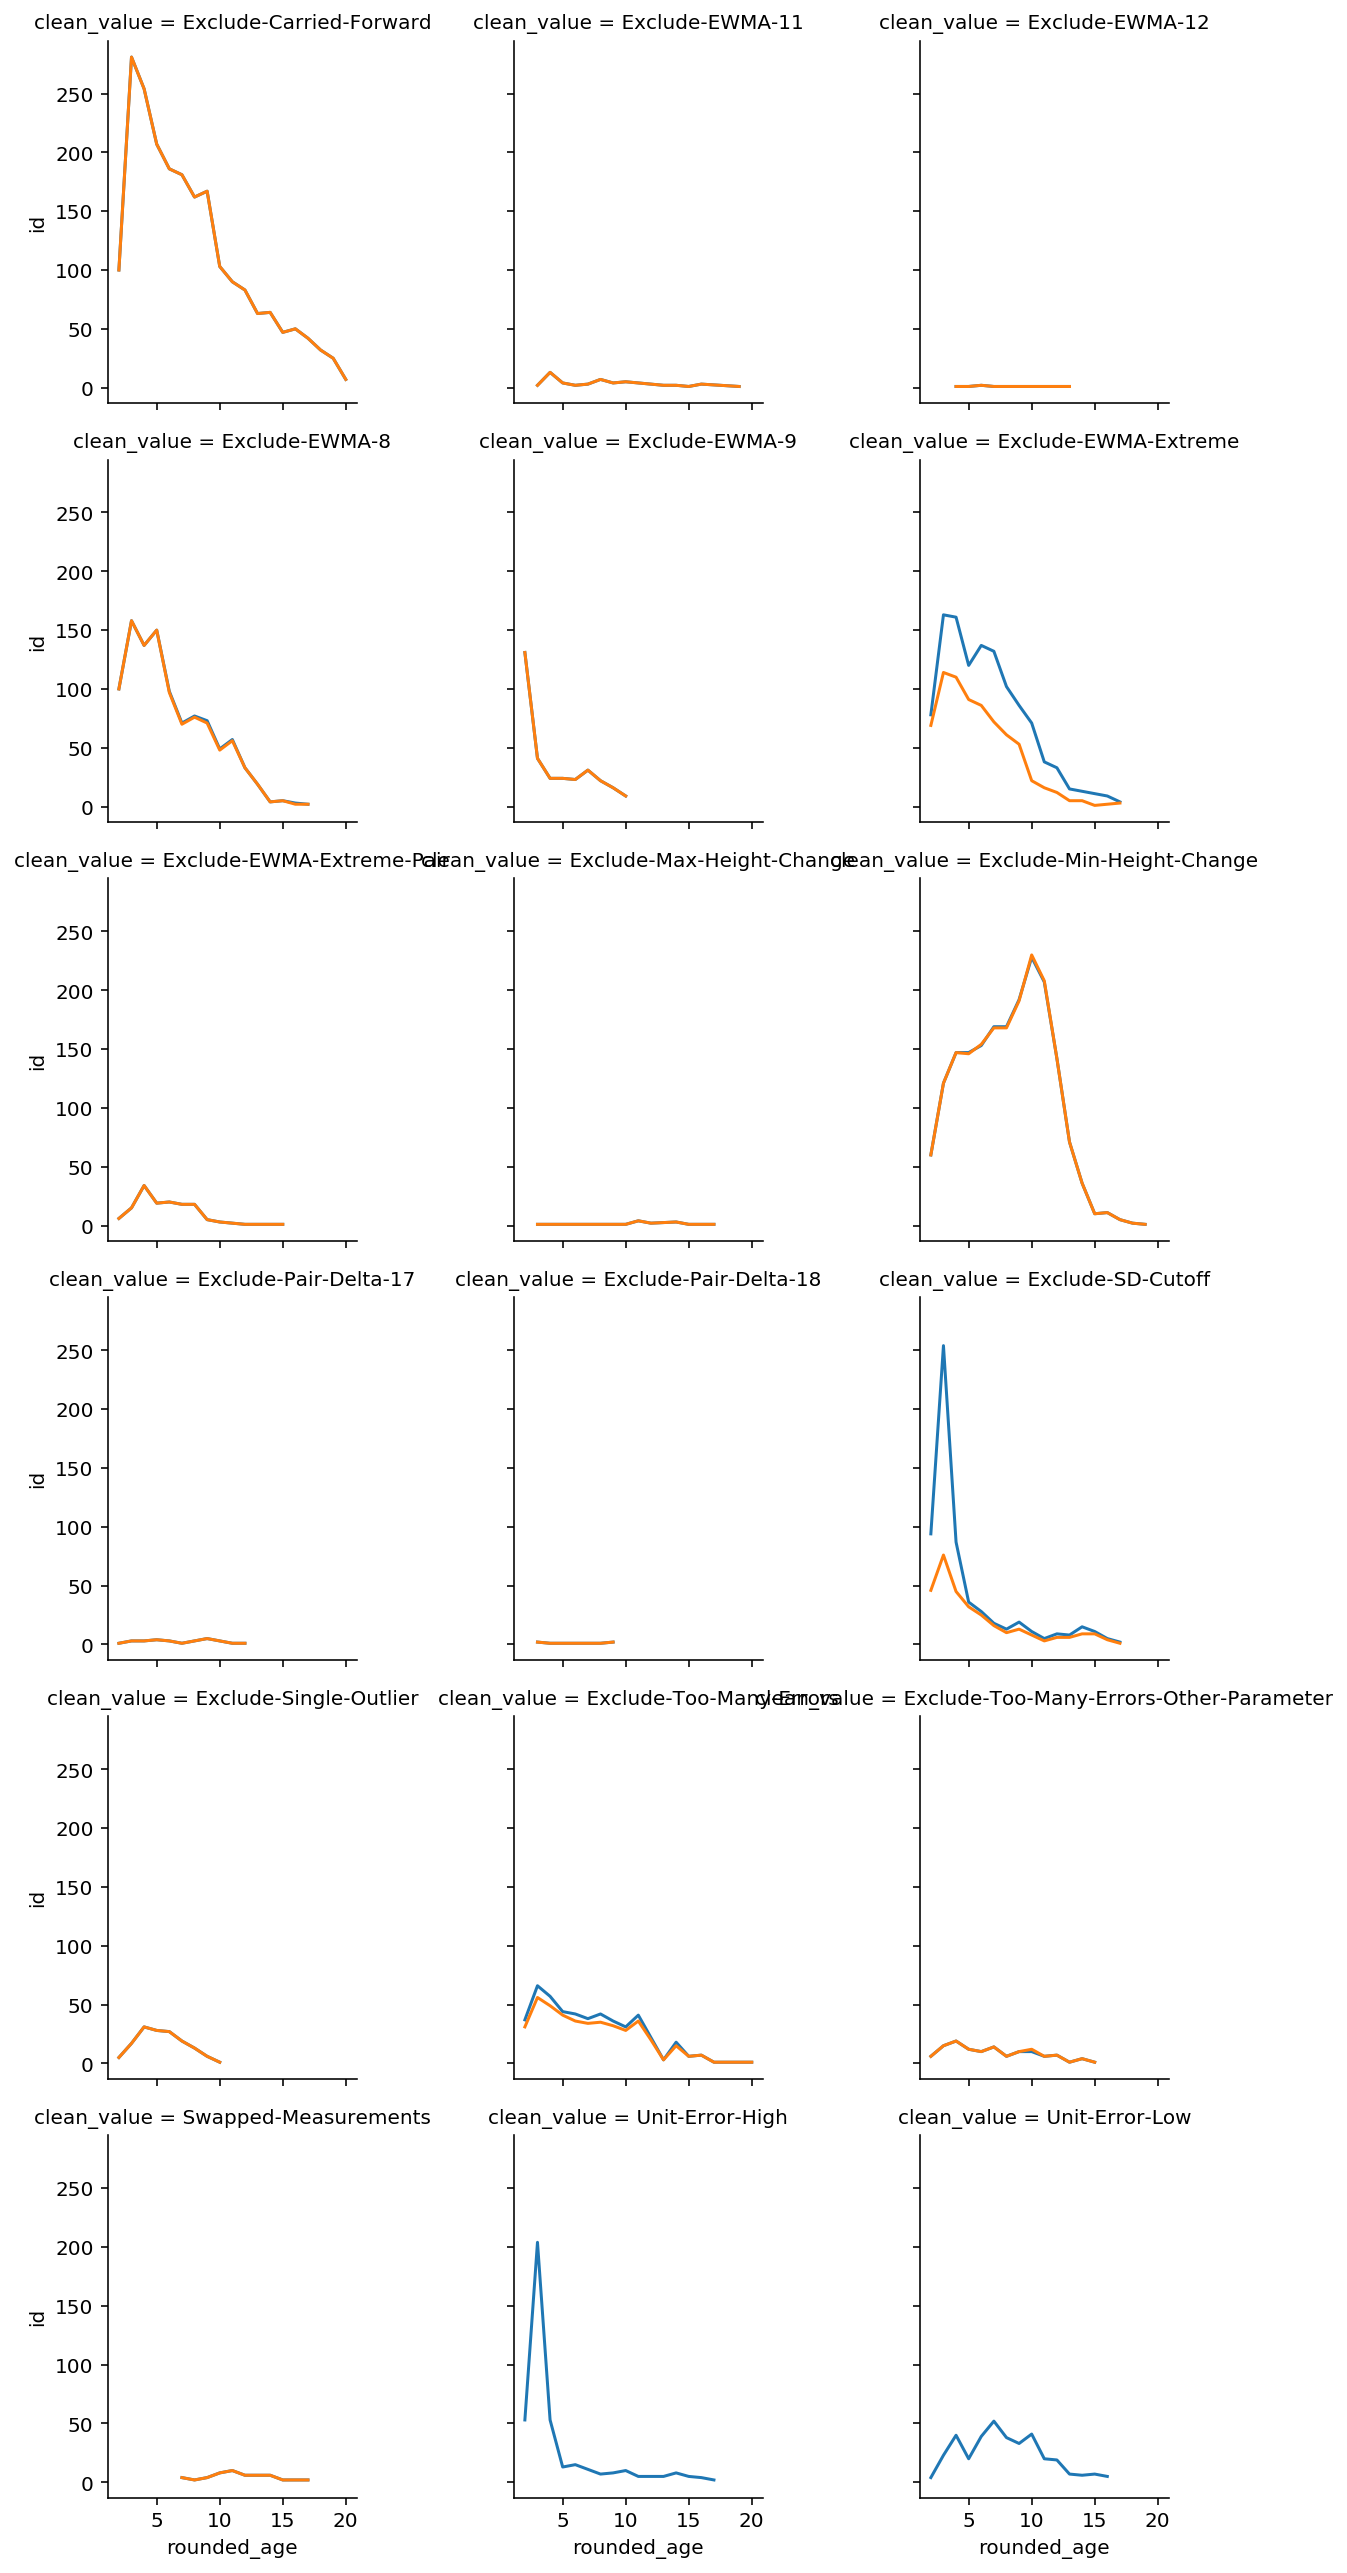

In [38]:
g = sns.FacetGrid(count_by_age[count_by_age.clean_value != 'Include'], col="clean_value", col_wrap=3)
g.map(sns.lineplot, 'rounded_age', 'id', 'run_name')
g

In [39]:
charts.subject_stats_comparison(combined)

,percent with exclusion,exclusions per patient
run name,,
swaps,33.329608,0.919303
unit errors,33.329608,0.912373
